1. We preprocess the data first
2. Let's first load the required libraries.
3. Load updated dataset that has already gone through preprocessing in the Preprocessing + Storage Google Collab Notebook
4. Dividing columns into two types of variables dependent(or target variable) and independent variable(or feature variables).
5. Dividing the dataset into a training set and a test set.
6. Ceating a Decision Tree Model using Scikit-learn.
7. Estimating how accurately the classifier or model can predict the type of cultivars. Accuracy can be computed by comparing actual test set values and predicted values.
8. Using Scikit-learn's export_graphviz function for display the tree.
9. Optimizing Decision Tree Performance


In [1]:
# Load libraries
import pandas as pd
import numpy as np
import io
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learnM metrics module for accuracy calculation
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
#Import svm model
from sklearn import svm

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


#Preprocessing

In [2]:
def get_mode(column):
    mode = []
    appear = dict((a, column.count(a)) for a in column)   # count appearance times of each key
    if max(appear.values()) == 1:       # if max time is 1
        return      # no mode here
    else:
        for k, v in appear.items():     # else, mode is the number which has max time
            if v == max(appear.values()):
                mode.append(k)
    return mode[0]  # return first number if has many modes

def fill_missing_values(dataframe_list, column_no):     # dataframe in the form of a list of lists
    size = len(dataframe_list)
    column_data = [x[column_no] for x in dataframe_list]      # get that column
    while '?' in column_data:
        column_data.remove('?')
    mode = get_mode(column_data)
    for i in range(size):
        if dataframe_list[i][column_no] == '?':
            dataframe_list[i][column_no] = mode              # fill in mode
    return dataframe_list

def get_discretization_data(data_column, class_label_column):
    size = len(data_column)
    result_list = []
    for i in range(size):
        result_list.append([data_column[i], class_label_column[i]])
    return result_list

def replace_numerical(dataframe_list, column_no, walls):
    size = len(dataframe_list)
    num_spilt_point = len(walls)
    for i in range(size):
        if dataframe_list[i][column_no] > walls[num_spilt_point - 1]:
            dataframe_list[i][column_no] = num_spilt_point + 1
            continue
        for j in range(0, num_spilt_point):
            if dataframe_list[i][column_no] <= walls[j]:
                dataframe_list[i][column_no] = j + 1
                break
    return dataframe_list

def replace_categorical(dataframe_list, column_no):
    size = len(dataframe_list)
    classes = set([x[column_no] for x in dataframe_list])
    classes_no = dict([(label, 0) for label in classes])
    j = 1
    for i in classes:
        classes_no[i] = j
        j += 1
    for i in range(size):
        dataframe_list[i][column_no] = classes_no[dataframe_list[i][column_no]]
    return dataframe_list, classes_no

def discard(dataframe_list, discard_list):
    size = len(dataframe_list)
    length = len(dataframe_list[0])
    data_result = []
    for i in range(size):
        data_result.append([])
        for j in range(length):
            if j not in discard_list:
                data_result[i].append(dataframe_list[i][j])
    return data_result

def pre_process(dataframe_list, attribute, value_type):
    column_num = len(dataframe_list[0])
    size = len(dataframe_list)
    class_column = [x[-1] for x in dataframe_list]
    discard_list = []
    for i in range(0, column_num - 1):
        data_column = [x[i] for x in dataframe_list]

        # process missing values
        missing_values_ratio = data_column.count('?') / size
        if missing_values_ratio > 0.5:
            discard_list.append(i)
            continue
        elif missing_values_ratio > 0:
            dataframe_list = fill_missing_values(dataframe_list, i)
            data_column = [x[i] for x in dataframe_list]

        # discretization
        if value_type[i] == 'numerical':
            discretization_data = get_discretization_data(data_column, class_column)
            block = Block(discretization_data)
            walls = partition(block)
            if len(walls) == 0:
                max_value = max(data_column)
                min_value = min(data_column)
                step = (max_value - min_value) / 3
                walls.append(min_value + step)
                walls.append(min_value + 2 * step)
            print(attribute[i] , ":", walls)        # print out split points
            dataframe_list = replace_numerical(dataframe_list, i, walls)
        elif value_type[i] == 'categorical':
            dataframe_list, classes_no = replace_categorical(dataframe_list, i)
            print(attribute[i] , ":", classes_no)   # print out replacement list

    # discard
    if len(discard_list) > 0:
        dataframe_list = discard(data, discard_list)
        print("discard:", discard_list)             # print out discard list
    return dataframe_list


import csv


# Read dataset and convert into a list.
# path: directory of *.data file.
def read_data(path):
    data = []
    with open(path, 'r') as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for line in reader:
            data.append(line)
        while [] in data:
            data.remove([])
    return data


# Read scheme file *.names and write down attributes and value types.
# path: directory of *.names file.
def read_scheme(path):
    with open(path, 'r') as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        attributes = next(reader)
        value_type = next(reader)
    return attributes, value_type


# convert string-type value into float-type.
# data: data list returned by read_data.
# value_type: list returned by read_scheme.
def str2numerical(data, value_type):
    #ct = 0
    #print("str2numerical")
    size = len(data) 
    columns = len(data[0])
    for i in range(size):
        #ct = 0
        for j in range(columns - 1):
            if value_type[j] == 'numerical' and data[i][j] != '?':
                #ct += 1
                data[i][j] = float(data[i][j])
        #print("ct: ",ct)
    return data


# Main method in this file, to get data list after processing and scheme list.
# data_path: tell where *.data file stores.
# scheme_path: tell where *.names file stores.
def read(data_path, scheme_path):
    data = read_data(data_path)
    attributes, value_type = read_scheme(scheme_path)
    data = str2numerical(data, value_type)
    return data, attributes, value_type




import math


# A block to be split
# It has 4 member:
#   data: the data table with a column of continuous-valued attribute and a column of class label
#   size: number of data case in this table
#   number_of_classes: obviously, the number of class in this table
#   entropy: entropy of dataset
class Block:
    def __init__(self, data):
        self.data = data
        self.size = len(data)
        classes = set([x[1] for x in data])     # get distinct class labels in this table
        self.number_of_classes = len(set(classes))
        self.entropy = calculate_entropy(data)


# Calculate the entropy of dataset
# parameter data: the data table to be used
def calculate_entropy(data):
    number_of_data = len(data)
    classes = set([x[1] for x in data])
    class_count = dict([(label, 0) for label in classes])
    for data_case in data:
        class_count[data_case[1]] += 1      # count the number of data case of each class
    entropy = 0
    for c in classes:
        p = class_count[c] / number_of_data
        entropy -= p * math.log2(p)         # calculate information entropy by its formula, where the base is 2
    return entropy


# Compute Gain(A, T: S) mentioned in Dougherty, Kohavi & Sahami (1995), i.e. entropy gained by splitting original_block
#   into left_block and right_block
# original_block: the block before partition
# left_block: the block split which its value below boundary
# right_block: the block above boundary
def entropy_gain(original_block, left_block, right_block):
    gain = original_block.entropy - \
            ((left_block.size / original_block.size) * left_block.entropy +
            (right_block.size / original_block.size) * right_block.entropy)
    return gain


# Get minimum entropy gain required for a split of original_block into 2 blocks "left" and "right", see Dougherty,
#   Kohavi & Sahami (1995)
# original_block: the block before partition
# left_block: the block split which its value below boundary
# right_block: the block above boundary
def min_gain(original_block, left_block, right_block):
    delta = math.log2(math.pow(3, original_block.number_of_classes) - 2) - \
            (original_block.number_of_classes * original_block.entropy -
             left_block.number_of_classes * left_block.entropy -
             right_block.number_of_classes * right_block.entropy)
    gain_sup = math.log2(original_block.size - 1) / original_block.size + delta / original_block.size
    return gain_sup


# Identify the best acceptable value to split block
# block: a block of dataset
# Return value: a list of (boundary, entropy gain, left block, right block) or
#   None when it's unnecessary to split
def split(block):
    candidates = [x[0] for x in block.data]     # candidates is a list of values can be picked up as boundary
    candidates = list(set(candidates))          # get different values in table
    candidates.sort()                           # sort ascending
    candidates = candidates[1:]                 # discard smallest, because by definition no value is smaller

    wall = []       # wall is a list storing final boundary
    for value in candidates:
        # split by value into 2 groups, below & above
        left_data = []
        right_data = []
        for data_case in block.data:
            if data_case[0] < value:
                left_data.append(data_case)
            else:
                right_data.append(data_case)

        left_block = Block(left_data)
        right_block = Block(right_data)

        gain = entropy_gain(block, left_block, right_block)
        threshold = min_gain(block, left_block, right_block)

        # minimum threshold is met, the value is an acceptable candidate
        if gain >= threshold:
            wall.append([value, gain, left_block, right_block])

    if wall:    # has candidate
        wall.sort(key=lambda wall: wall[1], reverse=True)   # sort descending by "gain"
        return wall[0]      # return best candidate with max entropy gain
    else:
        return None         # no need to split


# Top-down recursive partition of a data block, append boundary into "walls"
# block: a data block
def partition(block):
    walls = []

    # inner recursive function, accumulate the partitioning values
    # sub_block: just a data block
    def recursive_split(sub_block):
        wall_returned = split(sub_block)        # binary partition, get bin boundary
        if wall_returned:                       # still can be spilt
            walls.append(wall_returned[0])      # record this partitioning value
            recursive_split(wall_returned[2])   # recursively process left block
            recursive_split(wall_returned[3])   # recursively split right block
        else:
            return                              # end of recursion

    recursive_split(block)      # call inner function
    walls.sort()                # sort boundaries descending
    return walls



#Decision Tree

#Iris Dataset

In [3]:
data_path = '/content/drive/MyDrive/CZ4032/Dataset/To feed into classifier/iris.data' # only change filename here for different datasets
scheme_path = '/content/drive/MyDrive/CZ4032/Dataset/To feed into classifier/iris.names'
data, attributes, value_type = read(data_path, scheme_path)
df = pre_process(data, attributes, value_type)
print(df)
# opening the csv file in 'w+' mode
file = open('iris-Updated.csv', 'w+', newline ='')
import csv 
# writing the data into the file
with file:    
    write = csv.writer(file)
    write.writerows(df)

sepal_length : [5.6, 6.2]
sepal_width : [3.0, 3.4]
petal_length : [3.0, 4.8]
petal_width : [1.0, 1.8]
[[1, 3, 1, 1, 'Iris-setosa'], [1, 1, 1, 1, 'Iris-setosa'], [1, 2, 1, 1, 'Iris-setosa'], [1, 2, 1, 1, 'Iris-setosa'], [1, 3, 1, 1, 'Iris-setosa'], [1, 3, 1, 1, 'Iris-setosa'], [1, 2, 1, 1, 'Iris-setosa'], [1, 2, 1, 1, 'Iris-setosa'], [1, 1, 1, 1, 'Iris-setosa'], [1, 2, 1, 1, 'Iris-setosa'], [1, 3, 1, 1, 'Iris-setosa'], [1, 2, 1, 1, 'Iris-setosa'], [1, 1, 1, 1, 'Iris-setosa'], [1, 1, 1, 1, 'Iris-setosa'], [2, 3, 1, 1, 'Iris-setosa'], [2, 3, 1, 1, 'Iris-setosa'], [1, 3, 1, 1, 'Iris-setosa'], [1, 3, 1, 1, 'Iris-setosa'], [2, 3, 1, 1, 'Iris-setosa'], [1, 3, 1, 1, 'Iris-setosa'], [1, 2, 1, 1, 'Iris-setosa'], [1, 3, 1, 1, 'Iris-setosa'], [1, 3, 1, 1, 'Iris-setosa'], [1, 2, 1, 1, 'Iris-setosa'], [1, 2, 1, 1, 'Iris-setosa'], [1, 1, 1, 1, 'Iris-setosa'], [1, 2, 1, 1, 'Iris-setosa'], [1, 3, 1, 1, 'Iris-setosa'], [1, 2, 1, 1, 'Iris-setosa'], [1, 2, 1, 1, 'Iris-setosa'], [1, 2, 1, 1, 'Iris-setosa']

In [4]:
col_names = ['SepalLength','SepalWidth', 'PetalLength', 'PetalWidth', 'Class']
df = pd.read_csv('iris-Updated.csv', header=None, names=col_names)
  																			
rows = len(df)
cols = len(df.columns)
print(rows)
print(cols)
df.head()

150
5


SepalLength  SepalWidth  PetalLength  PetalWidth        Class
0            1           3            1           1  Iris-setosa
1            1           1            1           1  Iris-setosa
2            1           2            1           1  Iris-setosa
3            1           2            1           1  Iris-setosa
4            1           3            1           1  Iris-setosa

Accuracy: 0.9333333333333333


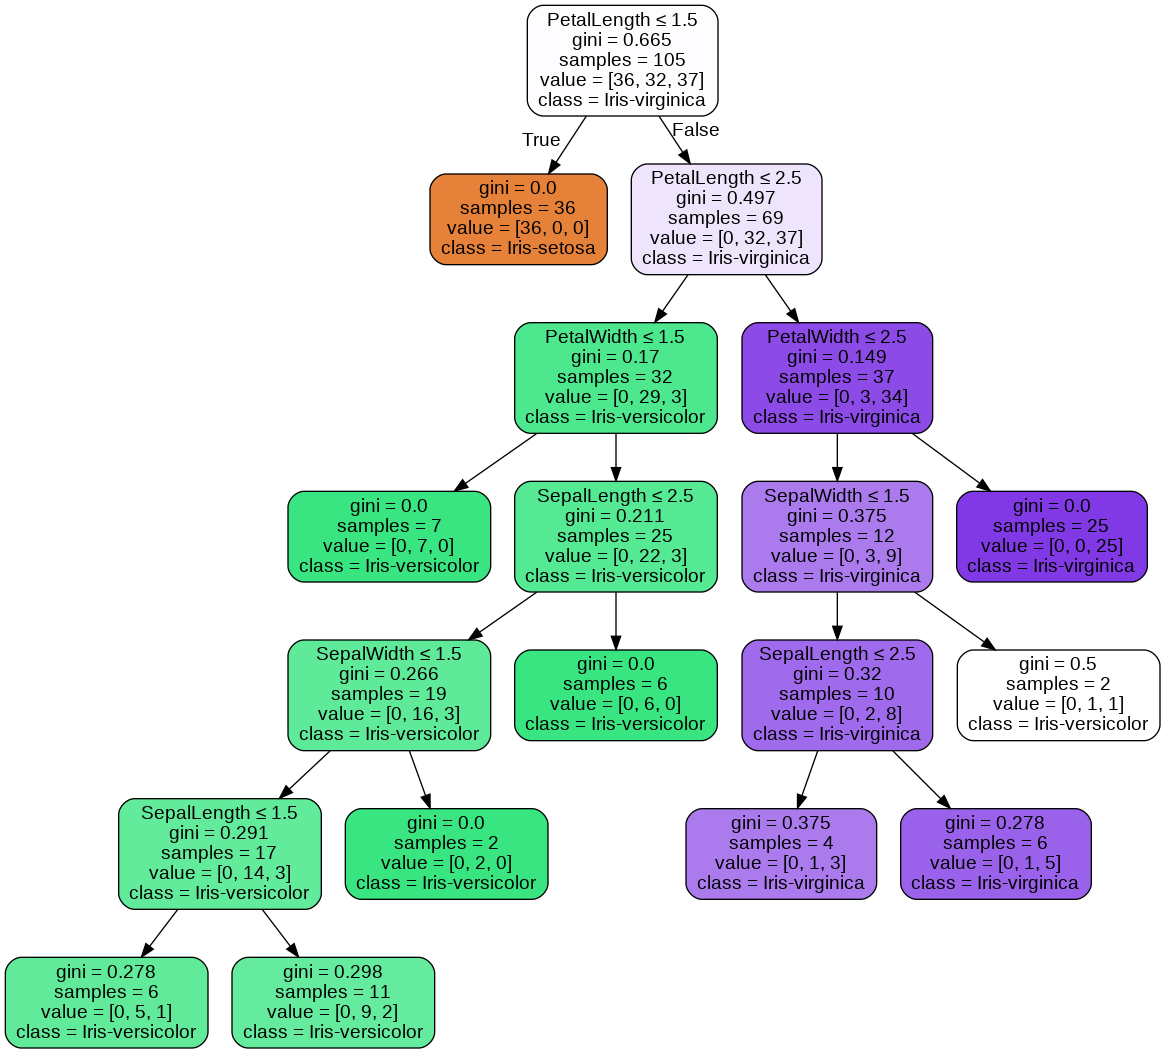

In [5]:
#split dataset in features and target variable
feature_cols = ['SepalLength','SepalWidth', 'PetalLength', 'PetalWidth']


X = df[feature_cols] # Features
y = df.Class # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['Iris-setosa','Iris-versicolor', 'Iris-virginica'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('iris.png')
Image(graph.create_png())

criterion : optional (default=”gini”) or Choose attribute selection     measure: This parameter allows us to use the different-different attribute selection measure. Supported criteria are “gini” for the Gini index and “entropy” for the information gain.

splitter : string, optional (default=”best”) or Split Strategy: This parameter allows us to choose the split strategy. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

max_depth : int or None, optional (default=None) or Maximum Depth of a Tree: The maximum depth **of** the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting

Accuracy: 0.9555555555555556


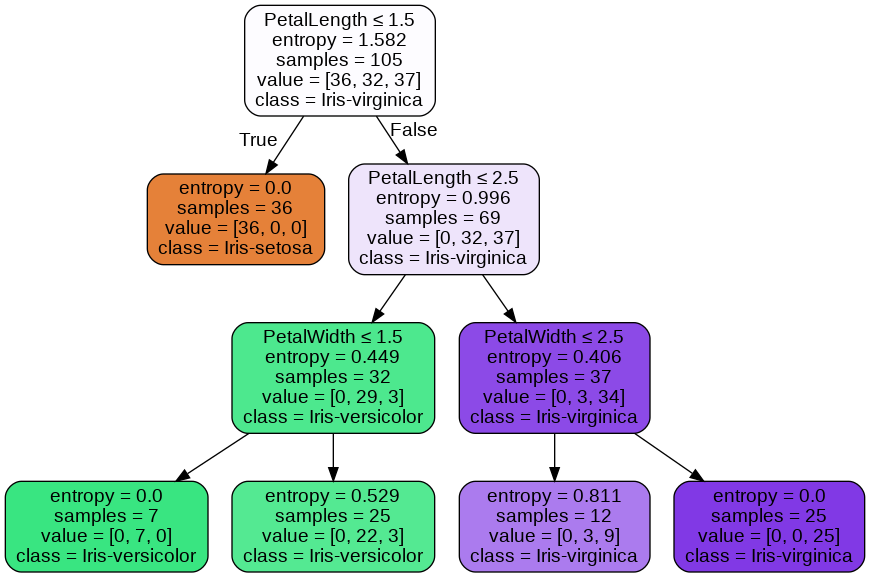

In [6]:
#Optimised Decision Tree

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Iris-setosa','Iris-versicolor', 'Iris-virginica'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('iris1.png')
Image(graph.create_png())

#Wine Dataset

In [7]:
data_path = '/content/drive/MyDrive/CZ4032/Dataset/To feed into classifier/wine.data' # only change filename here for different datasets
scheme_path = '/content/drive/MyDrive/CZ4032/Dataset/To feed into classifier/wine.names'
data, attributes, value_type = read(data_path, scheme_path)
df = pre_process(data, attributes, value_type)
print(df)
# opening the csv file in 'w+' mode
file = open('wine-Updated.csv', 'w+', newline ='')
import csv 
# writing the data into the file
with file:    
    write = csv.writer(file)
    write.writerows(df)

Alcohol : [12.2, 12.79]
Malic acid : [1.43, 2.31]
Ash : [2.04]
Alcalinity of ash : [18.0]
Magnesium : [89.0]
Total phenols : [1.85, 2.35]
Flavanoids : [0.99, 1.58, 2.33]
Nonflavanoid phenols : [0.4]
Proanthocyanins  : [1.28]
Color intensity : [3.52, 7.6]
Hue  : [0.79, 0.98, 1.31]
OD280/OD315 of diluted wines : [2.12, 2.48]
Proline : [470.0, 760.0, 990.0]
[[3, 2, 2, 1, 2, 3, 4, 1, 2, 2, 3, 3, 4, '1'], [3, 2, 2, 1, 2, 3, 4, 1, 1, 2, 3, 3, 4, '1'], [3, 3, 2, 2, 2, 3, 4, 1, 2, 2, 3, 3, 4, '1'], [3, 2, 2, 1, 2, 3, 4, 1, 2, 3, 2, 3, 4, '1'], [3, 3, 2, 2, 2, 3, 4, 1, 2, 2, 3, 3, 2, '1'], [3, 2, 2, 1, 2, 3, 4, 1, 2, 2, 3, 3, 4, '1'], [3, 2, 2, 1, 2, 3, 4, 1, 2, 2, 3, 3, 4, '1'], [3, 2, 2, 1, 2, 3, 4, 1, 1, 2, 3, 3, 4, '1'], [3, 2, 2, 1, 2, 3, 4, 1, 2, 2, 3, 3, 4, '1'], [3, 1, 2, 1, 2, 3, 4, 1, 2, 2, 3, 3, 4, '1'], [3, 2, 2, 1, 2, 3, 4, 1, 2, 2, 3, 3, 4, '1'], [3, 2, 2, 1, 2, 2, 4, 1, 2, 2, 3, 3, 4, '1'], [3, 2, 2, 1, 1, 3, 4, 1, 2, 2, 3, 3, 4, '1'], [3, 2, 2, 1, 2, 3, 4, 2, 2, 2, 3, 3, 4, '1']

In [8]:
col_names = ['Alcohol','MalicAcid', 'Ash', 'AlcalinityOfAsh', 'Magnesium', 'TotalPhenols', 'Flavanoids', 'NonflavanoidPhenols', 'Proanthocyanins', 'ColorIntensity', 'Hue', 'OD280_OD315OfDilutedWines', 'Proline']
df = pd.read_csv('wine-Updated.csv', header=None, names=col_names)
  																			
rows = len(df)
cols = len(df.columns)
print(rows)
print(cols)
df.head()

178
13


Alcohol  MalicAcid  Ash  ...  Hue  OD280_OD315OfDilutedWines  Proline
3        2          2    1  ...    3                          4        1
3        2          2    1  ...    3                          4        1
3        3          2    2  ...    3                          4        1
3        2          2    1  ...    3                          4        1
3        3          2    2  ...    3                          2        1

[5 rows x 13 columns]

In [9]:
#split dataset in features and target variable
feature_cols = ['Alcohol','MalicAcid', 'Ash', 'AlcalinityOfAsh', 'Magnesium', 'TotalPhenols', 'Flavanoids', 'NonflavanoidPhenols', 'Proanthocyanins', 'ColorIntensity', 'Hue', 'OD280_OD315OfDilutedWines']


X = df[feature_cols] # Features
y = df.Proline # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#Print out the decision tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['1.0','2.0','3.0'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('wine.png')
Image(graph.create_png())

Accuracy: 0.9629629629629629


In [10]:
#Optimised Decision Tree

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['1.0','2.0','3.0'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('wine1.png')
Image(graph.create_png())

Accuracy: 0.9074074074074074


#Glass Dataset

In [11]:
data_path = '/content/drive/MyDrive/CZ4032/Dataset/To feed into classifier/glass.data' # only change filename here for different datasets
scheme_path = '/content/drive/MyDrive/CZ4032/Dataset/To feed into classifier/glass.names'
data, attributes, value_type = read(data_path, scheme_path)
df = pre_process(data, attributes, value_type)
print(df)
# opening the csv file in 'w+' mode
file = open('glass-Updated.csv', 'w+', newline ='')
import csv 
# writing the data into the file
with file:    
    write = csv.writer(file)
    write.writerows(df)

Id number : [71.0, 147.0, 164.0, 177.0, 186.0]
RI : [1.51735, 1.518]
Na : [14.09]
Mg : [2.71]
Al : [1.4, 1.79]
Si : [71.67666666666666, 73.54333333333334]
K : [0.06, 0.62, 0.76]
Ca : [7.08, 8.32, 10.09]
Ba : [0.4]
Fe : [0.17, 0.34]
[[1, 3, 1, 2, 1, 2, 1, 3, 1, 1, '1'], [1, 2, 1, 2, 1, 2, 2, 2, 1, 1, '1'], [1, 1, 1, 2, 2, 2, 2, 2, 1, 1, '1'], [1, 2, 1, 2, 1, 2, 2, 2, 1, 1, '1'], [1, 2, 1, 2, 1, 2, 2, 2, 1, 1, '1'], [1, 1, 1, 2, 2, 2, 3, 2, 1, 2, '1'], [1, 2, 1, 2, 1, 2, 2, 2, 1, 1, '1'], [1, 2, 1, 2, 1, 2, 2, 2, 1, 1, '1'], [1, 3, 1, 2, 1, 2, 2, 2, 1, 1, '1'], [1, 2, 1, 2, 1, 2, 2, 3, 1, 1, '1'], [1, 1, 1, 2, 2, 2, 3, 2, 1, 2, '1'], [1, 2, 1, 2, 1, 2, 2, 3, 1, 1, '1'], [1, 1, 1, 2, 1, 2, 3, 2, 1, 2, '1'], [1, 2, 1, 2, 1, 2, 2, 3, 1, 1, '1'], [1, 2, 1, 2, 1, 2, 2, 3, 1, 1, '1'], [1, 2, 1, 2, 1, 2, 2, 3, 1, 1, '1'], [1, 2, 1, 2, 1, 2, 2, 3, 1, 1, '1'], [1, 3, 2, 2, 1, 1, 2, 3, 1, 1, '1'], [1, 3, 1, 2, 1, 2, 1, 3, 1, 1, '1'], [1, 1, 1, 2, 2, 2, 2, 3, 1, 1, '1'], [1, 2, 1, 2, 2, 2, 2, 3, 1,

In [12]:
col_names = ['IdNumber','RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
df = pd.read_csv('glass-Updated.csv', header=None, names=col_names)
  																			
rows = len(df)
cols = len(df.columns)
print(rows)
print(cols)
df.head()

214
10


IdNumber  RI  Na  Mg  Al  Si  K  Ca  Ba  Fe
1         3   1   2   1   2   1  3   1   1   1
1         2   1   2   1   2   2  2   1   1   1
1         1   1   2   2   2   2  2   1   1   1
1         2   1   2   1   2   2  2   1   1   1
1         2   1   2   1   2   2  2   1   1   1

Accuracy: 0.7384615384615385


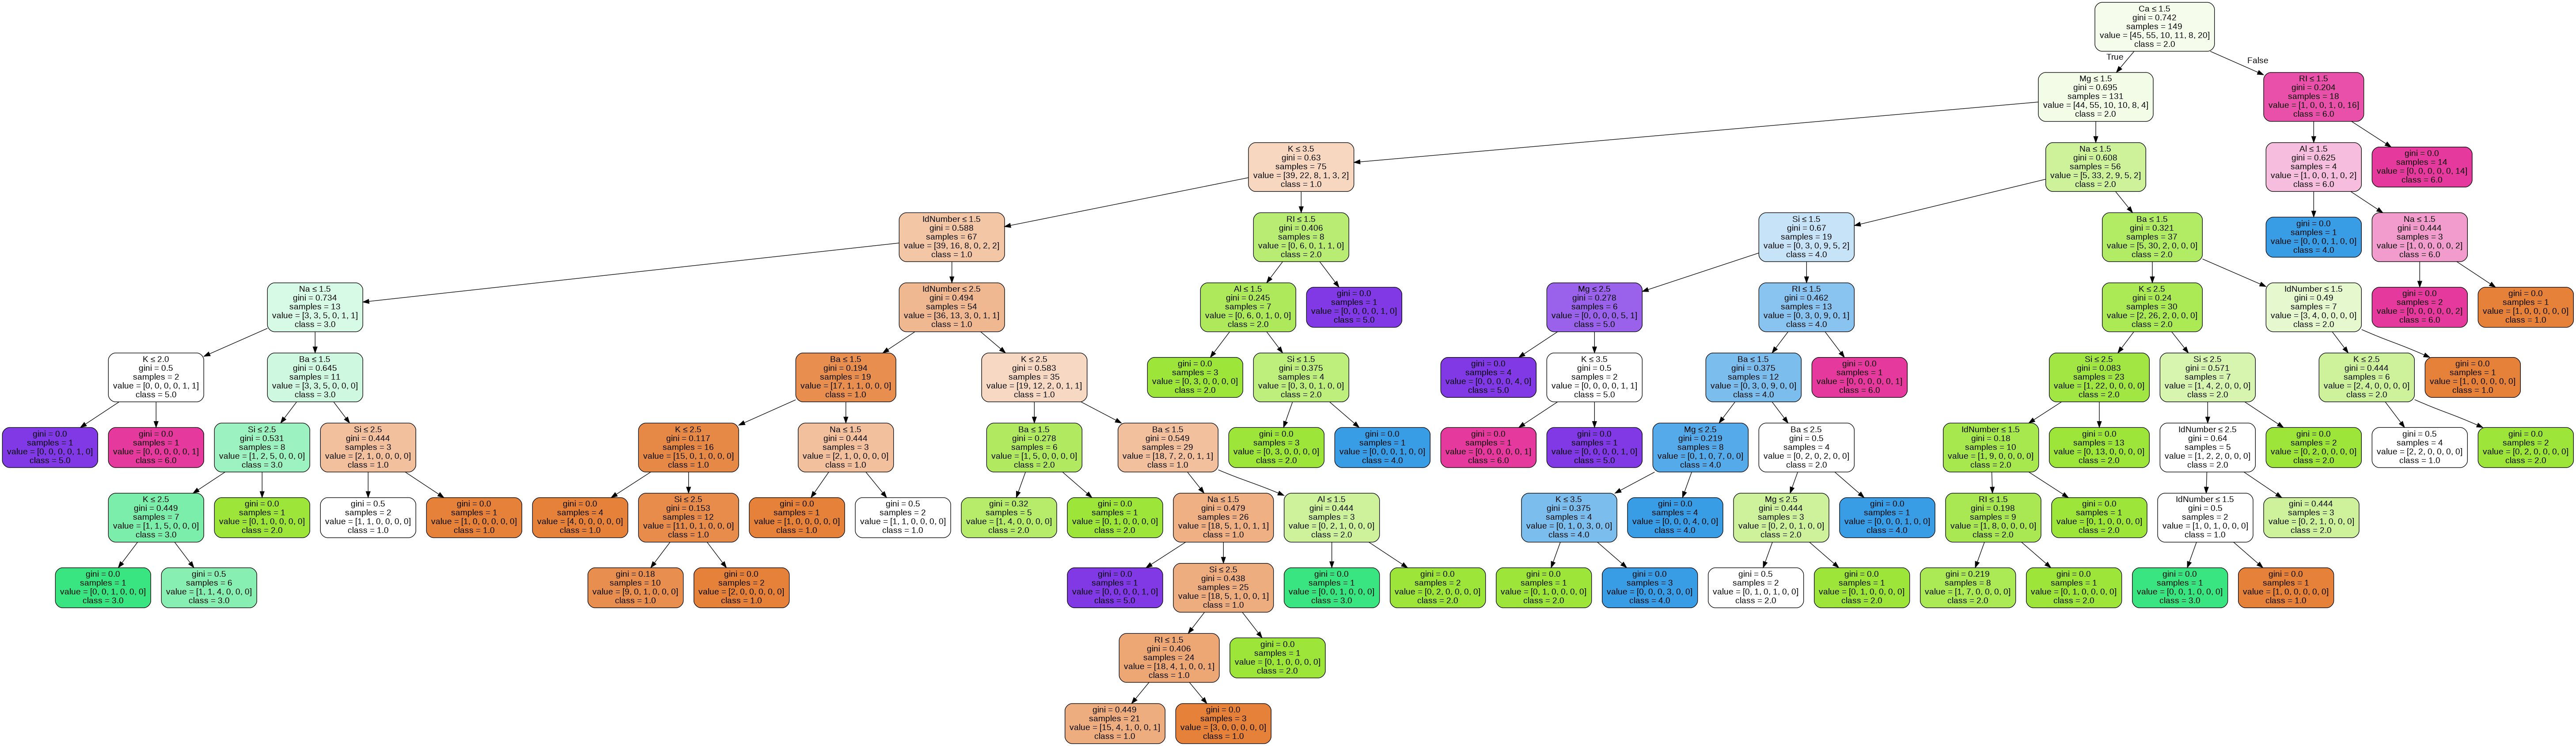

In [13]:
#split dataset in features and target variable
feature_cols = ['IdNumber','RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba']


X = df[feature_cols] # Features
y = df.Fe # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#Print out the decision tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['1.0','2.0','3.0','4.0','5.0','6.0', '7.0'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('glass.png')
Image(graph.create_png())

Accuracy: 0.676923076923077


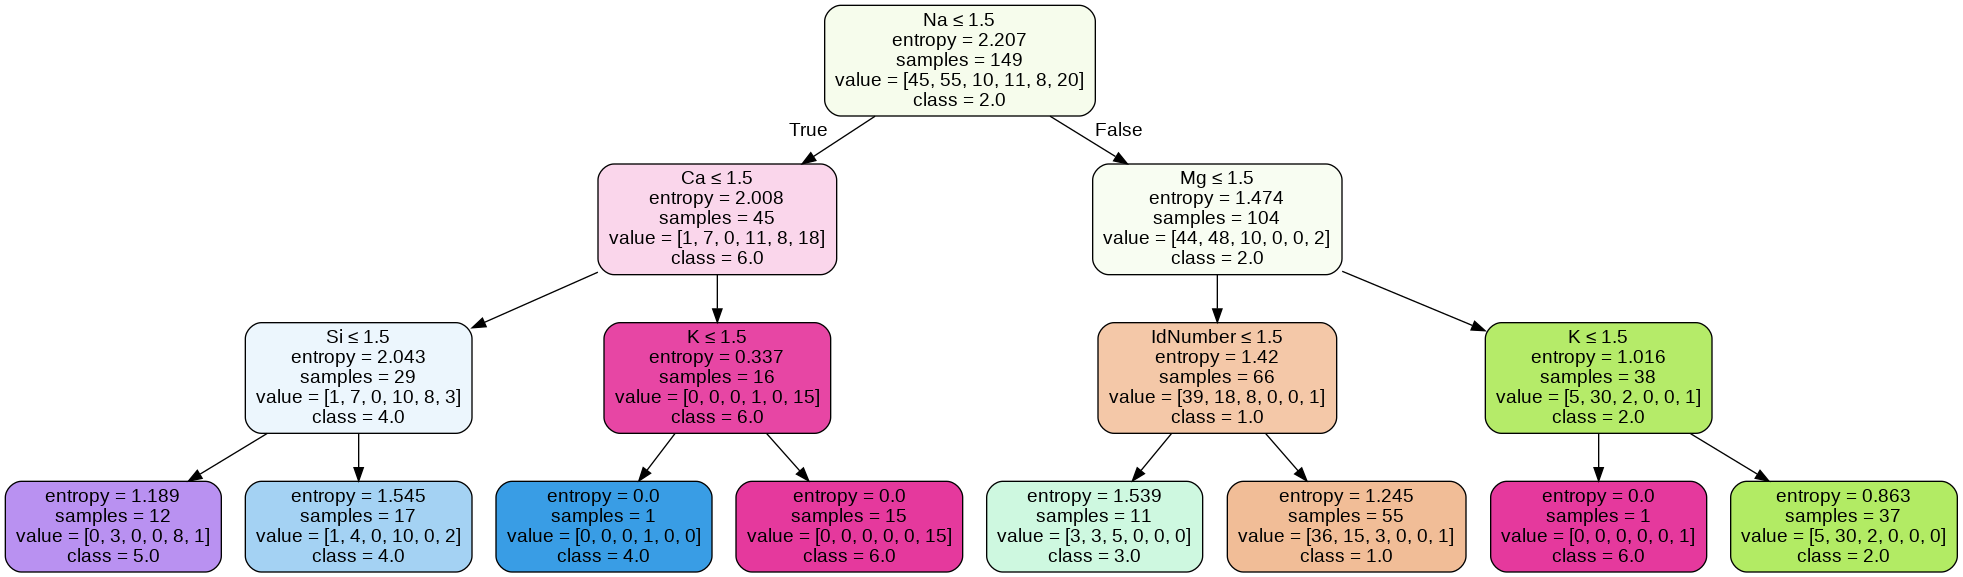

In [14]:
#Optimised Decision Tree

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['1.0','2.0','3.0','4.0','5.0','6.0', '7.0'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('glass1.png')
Image(graph.create_png())

#Zoo Dataset

In [15]:
data_path = '/content/drive/MyDrive/CZ4032/Dataset/To feed into classifier/zoo.data' # only change filename here for different datasets
scheme_path = '/content/drive/MyDrive/CZ4032/Dataset/To feed into classifier/zoo.names'
data, attributes, value_type = read(data_path, scheme_path)
df = pre_process(data, attributes, value_type)
print(df)
# opening the csv file in 'w+' mode
file = open('zoo-Updated.csv', 'w+', newline ='')
import csv 
# writing the data into the file
with file:    
    write = csv.writer(file)
    write.writerows(df)

animal name : {'vulture': 1, 'sole': 2, 'scorpion': 3, 'slug': 4, 'hamster': 5, 'chub': 6, 'stingray': 7, 'oryx': 8, 'cavy': 9, 'dogfish': 10, 'tuatara': 11, 'lobster': 12, 'worm': 13, 'deer': 14, 'toad': 15, 'seahorse': 16, 'aardvark': 17, 'sparrow': 18, 'seawasp': 19, 'pony': 20, 'crab': 21, 'porpoise': 22, 'ladybird': 23, 'vampire': 24, 'starfish': 25, 'fruitbat': 26, 'piranha': 27, 'elephant': 28, 'vole': 29, 'skimmer': 30, 'swan': 31, 'crayfish': 32, 'crow': 33, 'ostrich': 34, 'pussycat': 35, 'bass': 36, 'tuna': 37, 'pheasant': 38, 'platypus': 39, 'penguin': 40, 'boar': 41, 'hare': 42, 'flamingo': 43, 'reindeer': 44, 'seasnake': 45, 'termite': 46, 'wren': 47, 'rhea': 48, 'mink': 49, 'buffalo': 50, 'herring': 51, 'honeybee': 52, 'flea': 53, 'catfish': 54, 'lynx': 55, 'antelope': 56, 'cheetah': 57, 'lion': 58, 'mole': 59, 'squirrel': 60, 'gull': 61, 'dolphin': 62, 'sealion': 63, 'pike': 64, 'raccoon': 65, 'opossum': 66, 'gorilla': 67, 'leopard': 68, 'gnat': 69, 'chicken': 70, 'house

In [16]:
col_names = ['animal_name','hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize', 'Type']
df = pd.read_csv('zoo-Updated.csv', header=None, names=col_names)
																				
rows = len(df)
cols = len(df.columns)
print(rows)
print(cols)
df.head()

101
18


animal_name  hair  feathers  eggs  milk  ...  legs  tail  domestic  catsize  Type
0           17     2         1     1     2  ...     6     1         1        2     1
1           56     2         1     1     2  ...     6     2         1        2     1
2           36     1         1     2     1  ...     3     2         1        1     4
3           85     2         1     1     2  ...     6     1         1        2     1
4           41     2         1     1     2  ...     6     2         1        2     1

[5 rows x 18 columns]

In [17]:
#split dataset in features and target variable
feature_cols = ['animal_name','hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize']


X = df[feature_cols] # Features
y = df.Type # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#Print out the decision tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['1','2','3','4','5','6','7'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Zoo.png')
Image(graph.create_png())

Accuracy: 0.9354838709677419


Accuracy: 0.8387096774193549


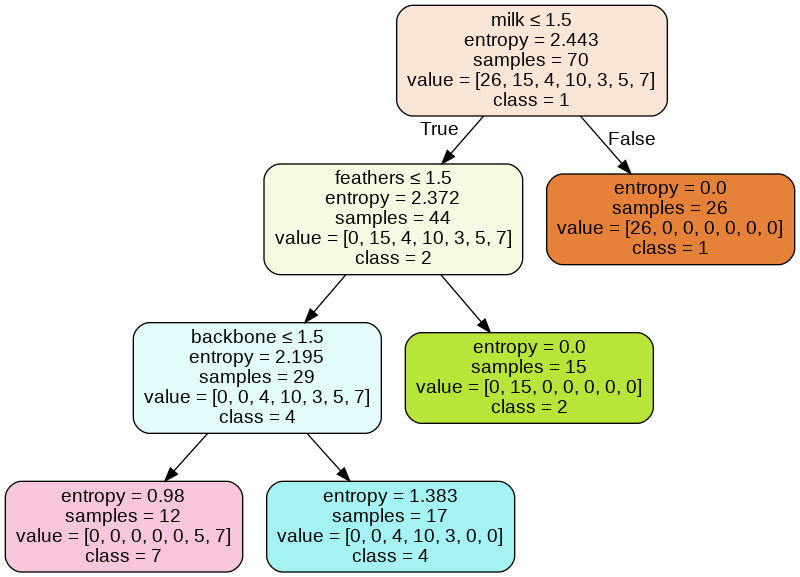

In [18]:
#Optimised Decision Tree

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['1','2','3','4','5','6','7'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('zoo1.png')
Image(graph.create_png())

#Tic-Tac-Toe

In [19]:
data_path = '/content/drive/MyDrive/CZ4032/Dataset/To feed into classifier/tic-tac-toe.data' # only change filename here for different datasets
scheme_path = '/content/drive/MyDrive/CZ4032/Dataset/To feed into classifier/tic-tac-toe.names'
data, attributes, value_type = read(data_path, scheme_path)
df = pre_process(data, attributes, value_type)
print(df)
# opening the csv file in 'w+' mode
file = open('tic-tac-toe-Updated.csv', 'w+', newline ='')
import csv 
# writing the data into the file
with file:    
    write = csv.writer(file)
    write.writerows(df)

top-left-square : {'o': 1, 'x': 2, 'b': 3}
top-middle-square : {'o': 1, 'x': 2, 'b': 3}
top-right-square : {'o': 1, 'x': 2, 'b': 3}
middle-left-square : {'o': 1, 'x': 2, 'b': 3}
middle-middle-square : {'o': 1, 'x': 2, 'b': 3}
middle-right-square : {'o': 1, 'x': 2, 'b': 3}
bottom-left-square : {'o': 1, 'x': 2, 'b': 3}
bottom-middle-square : {'o': 1, 'x': 2, 'b': 3}
bottom-right-square : {'o': 1, 'x': 2, 'b': 3}
[[2, 2, 2, 2, 1, 1, 2, 1, 1, 'positive'], [2, 2, 2, 2, 1, 1, 1, 2, 1, 'positive'], [2, 2, 2, 2, 1, 1, 1, 1, 2, 'positive'], [2, 2, 2, 2, 1, 1, 1, 3, 3, 'positive'], [2, 2, 2, 2, 1, 1, 3, 1, 3, 'positive'], [2, 2, 2, 2, 1, 1, 3, 3, 1, 'positive'], [2, 2, 2, 2, 1, 3, 1, 1, 3, 'positive'], [2, 2, 2, 2, 1, 3, 1, 3, 1, 'positive'], [2, 2, 2, 2, 1, 3, 3, 1, 1, 'positive'], [2, 2, 2, 2, 3, 1, 1, 1, 3, 'positive'], [2, 2, 2, 2, 3, 1, 1, 3, 1, 'positive'], [2, 2, 2, 2, 3, 1, 3, 1, 1, 'positive'], [2, 2, 2, 1, 2, 1, 2, 1, 1, 'positive'], [2, 2, 2, 1, 2, 1, 1, 2, 1, 'positive'], [2, 2, 2, 1

In [20]:
col_names = ['top-left-square','top-middle-square', 'top-right-square', 'middle-left-square', 'middle-middle-square', 'middle-right-square', 'bottom-left-square', 'bottom-middle-square', 'bottom-right-square', 'Class']
df = pd.read_csv('tic-tac-toe-Updated.csv', header=None, names=col_names)
																				
rows = len(df)
cols = len(df.columns)
print(rows)
print(cols)
df.head()

958
10


top-left-square  top-middle-square  ...  bottom-right-square     Class
0                2                  2  ...                    1  positive
1                2                  2  ...                    1  positive
2                2                  2  ...                    2  positive
3                2                  2  ...                    3  positive
4                2                  2  ...                    3  positive

[5 rows x 10 columns]

In [21]:
#split dataset in features and target variable
feature_cols = ['top-left-square','top-middle-square', 'top-right-square', 'middle-left-square', 'middle-middle-square', 'middle-right-square', 'bottom-left-square', 'bottom-middle-square', 'bottom-right-square']


X = df[feature_cols] # Features
y = df.Class # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#Print out the decision tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Positive','Negative'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('TTT.png')
Image(graph.create_png())

Accuracy: 0.9340277777777778


Accuracy: 0.7118055555555556


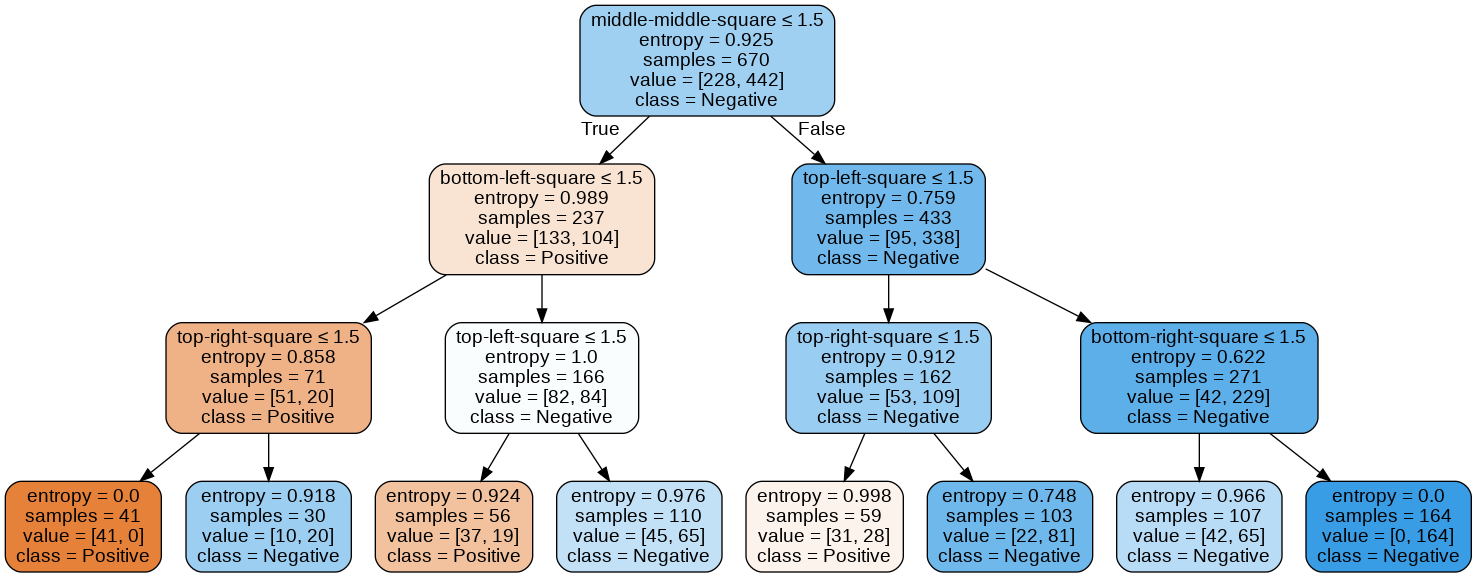

In [22]:
#Optimised Decision Tree

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Positive','Negative'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('TTT1.png')
Image(graph.create_png())

#Tae

In [23]:
data_path = '/content/drive/MyDrive/CZ4032/Dataset/To feed into classifier/tae.data' # only change filename here for different datasets
scheme_path = '/content/drive/MyDrive/CZ4032/Dataset/To feed into classifier/tae.names'
data, attributes, value_type = read(data_path, scheme_path)
df = pre_process(data, attributes, value_type)
print(df)
# opening the csv file in 'w+' mode
file = open('tae-Updated.csv', 'w+', newline ='')
import csv 
# writing the data into the file
with file:    
    write = csv.writer(file)
    write.writerows(df)

Course_instructor : {'20': 1, '1': 2, '18': 3, '5': 4, '7': 5, '13': 6, '24': 7, '3': 8, '21': 9, '23': 10, '25': 11, '16': 12, '14': 13, '15': 14, '22': 15, '17': 16, '6': 17, '10': 18, '8': 19, '19': 20, '11': 21, '2': 22, '4': 23, '12': 24, '9': 25}
Course : {'20': 1, '1': 2, '18': 3, '5': 4, '7': 5, '13': 6, '3': 7, '24': 8, '21': 9, '25': 10, '23': 11, '16': 12, '14': 13, '15': 14, '22': 15, '17': 16, '6': 17, '10': 18, '8': 19, '26': 20, '19': 21, '11': 22, '2': 23, '4': 24, '12': 25, '9': 26}
 Class_size : [24.0, 45.0]
[['1', 10, 7, '1', 1, '3'], ['2', 14, 7, '1', 1, '3'], ['1', 10, 7, '2', 3, '3'], ['1', 4, 23, '2', 2, '3'], ['2', 5, 22, '2', 3, '3'], ['2', 10, 7, '1', 1, '3'], ['2', 25, 4, '2', 1, '3'], ['2', 18, 7, '2', 2, '3'], ['1', 15, 7, '1', 3, '3'], ['2', 14, 7, '1', 1, '3'], ['2', 18, 15, '2', 1, '3'], ['2', 6, 2, '2', 2, '3'], ['2', 3, 9, '2', 2, '3'], ['2', 17, 16, '2', 2, '3'], ['2', 17, 16, '2', 2, '2'], ['2', 17, 16, '2', 2, '2'], ['2', 5, 22, '2', 1, '2'], ['2', 

In [24]:
col_names = ['TA_native_English_speaker','Course_instructor','Course','Summer_or_regular_semester', 'Class_size','Class']
df = pd.read_csv('tic-tac-toe-Updated.csv', header=None, names=col_names)
																				
rows = len(df)
cols = len(df.columns)
print(rows)
print(cols)
df.head()

958
6


TA_native_English_speaker  Course_instructor  ...  Class_size     Class
2 2 2 2                          1                  1  ...           1  positive
      2                          1                  1  ...           1  positive
      2                          1                  1  ...           2  positive
      2                          1                  1  ...           3  positive
      2                          1                  1  ...           3  positive

[5 rows x 6 columns]

In [25]:
#split dataset in features and target variable
feature_cols = ['TA_native_English_speaker','Course_instructor','Course','Summer_or_regular_semester', 'Class_size']


X = df[feature_cols] # Features
y = df.Class # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#Print out the decision tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['1','2','3'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('TTT.png')
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

Accuracy: 0.7013888888888888


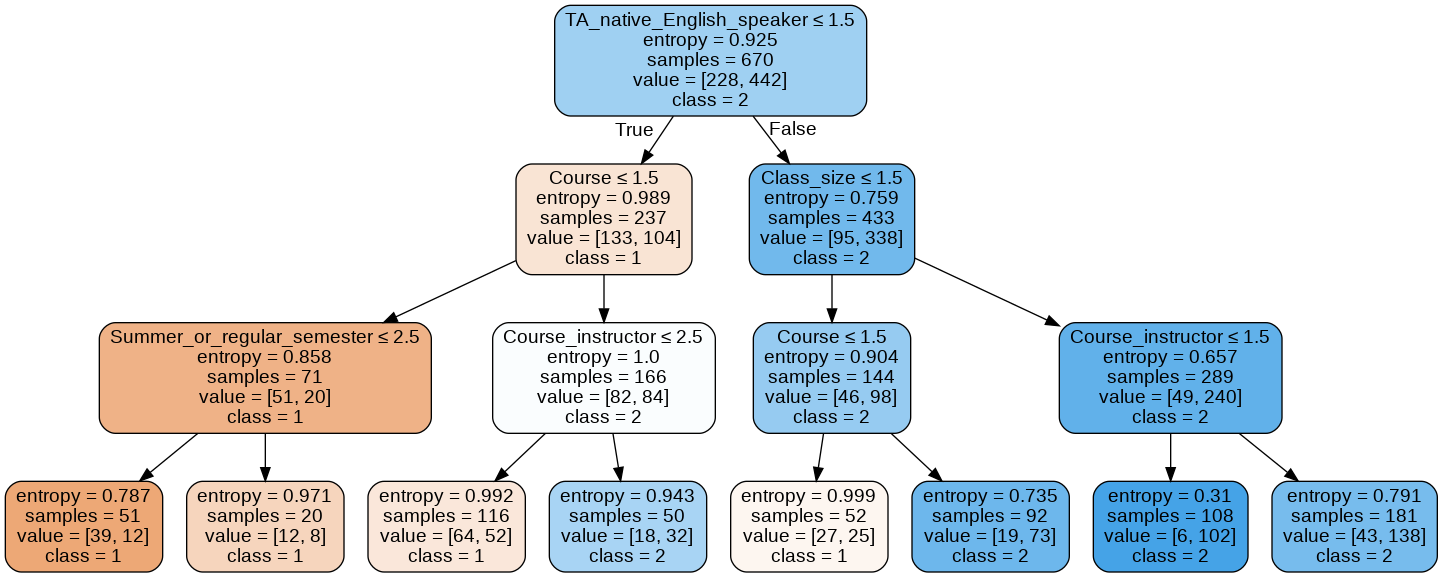

In [26]:
#Optimised Decision Tree

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['1','2','3'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('TTT1.png')
Image(graph.create_png())

#Breast_Cancer

In [27]:
df = pd.read_csv('BreastCancerCoimbraDataSet.csv', header= None)
df.head()
rows = len(df)
cols = len(df.columns)
print(rows)
print(cols)
df.head()

df = df.values.tolist() #convert dataframe to list of lists
test_attribute = [0,1,2,3,4,5,6,7,8,9]
test_value_type = ['numerical', 'numerical', 'numerical','numerical','numerical','numerical','numerical','numerical','numerical' 'label']
test_data_after = pre_process(df, test_attribute, test_value_type)
print(test_data_after)

# opening the csv file in 'w+' mode
file = open('BreastCancerCoimbraDataSet-Updated.csv', 'w+', newline ='')
import csv 
# writing the data into the file
with file:    
    write = csv.writer(file)
    write.writerows(test_data_after)

116
10
0 : [38.0]
1 : [25.106252846666667, 31.842505693333337]
2 : [92.0]
3 : [21.107999999999997, 39.784]
4 : [2.241625267]
5 : [32.96733333333333, 61.623666666666665]
6 : [13.784013333333334, 25.91200666666667]
7 : [29.506666666666668, 55.803333333333335]
[[2, 1, 1, 1, 1, 1, 1, 1, 417.11400000000003, 1.0], [2, 1, 1, 1, 1, 1, 1, 1, 468.786, 1.0], [2, 1, 1, 1, 1, 1, 2, 1, 554.697, 1.0], [2, 1, 1, 1, 1, 1, 1, 1, 928.22, 1.0], [2, 1, 1, 1, 1, 1, 1, 1, 773.92, 1.0], [2, 1, 1, 1, 1, 1, 1, 1, 530.41, 1.0], [2, 1, 1, 1, 1, 1, 1, 1, 1256.083, 1.0], [2, 1, 2, 1, 1, 1, 1, 1, 280.694, 1.0], [2, 1, 2, 1, 1, 1, 1, 1, 136.855, 1.0], [2, 1, 1, 1, 1, 1, 1, 1, 318.302, 1.0], [1, 1, 1, 1, 1, 1, 1, 1, 354.6, 1.0], [1, 1, 1, 1, 1, 2, 3, 1, 174.8, 1.0], [1, 1, 1, 1, 1, 1, 2, 1, 313.73, 1.0], [1, 1, 1, 1, 1, 1, 3, 1, 632.22, 1.0], [1, 1, 1, 1, 1, 1, 2, 1, 165.02, 1.0], [2, 1, 1, 1, 1, 1, 2, 1, 63.61, 1.0], [2, 1, 1, 1, 1, 1, 3, 1, 191.72, 1.0], [2, 3, 1, 1, 2, 1, 1, 1, 444.395, 1.0], [2, 3, 2, 1, 1, 1, 1, 

In [28]:
col_names = ['Age','BMI','Glucose','Insulin','HOMA','Leptin','Adiponectin','Resistin	MCP.1','Classification']
df = pd.read_csv('BreastCancerCoimbraDataSet-Updated.csv', header=None, names=col_names)
																				
rows = len(df)
cols = len(df.columns)
print(rows)
print(cols)
df.head()

116
9


Age  BMI  Glucose  ...  Adiponectin  Resistin\tMCP.1  Classification
2    1    1        1  ...            1          417.114             1.0
2    1    1        1  ...            1          468.786             1.0
2    1    1        1  ...            1          554.697             1.0
2    1    1        1  ...            1          928.220             1.0
2    1    1        1  ...            1          773.920             1.0

[5 rows x 9 columns]

Accuracy: 0.6


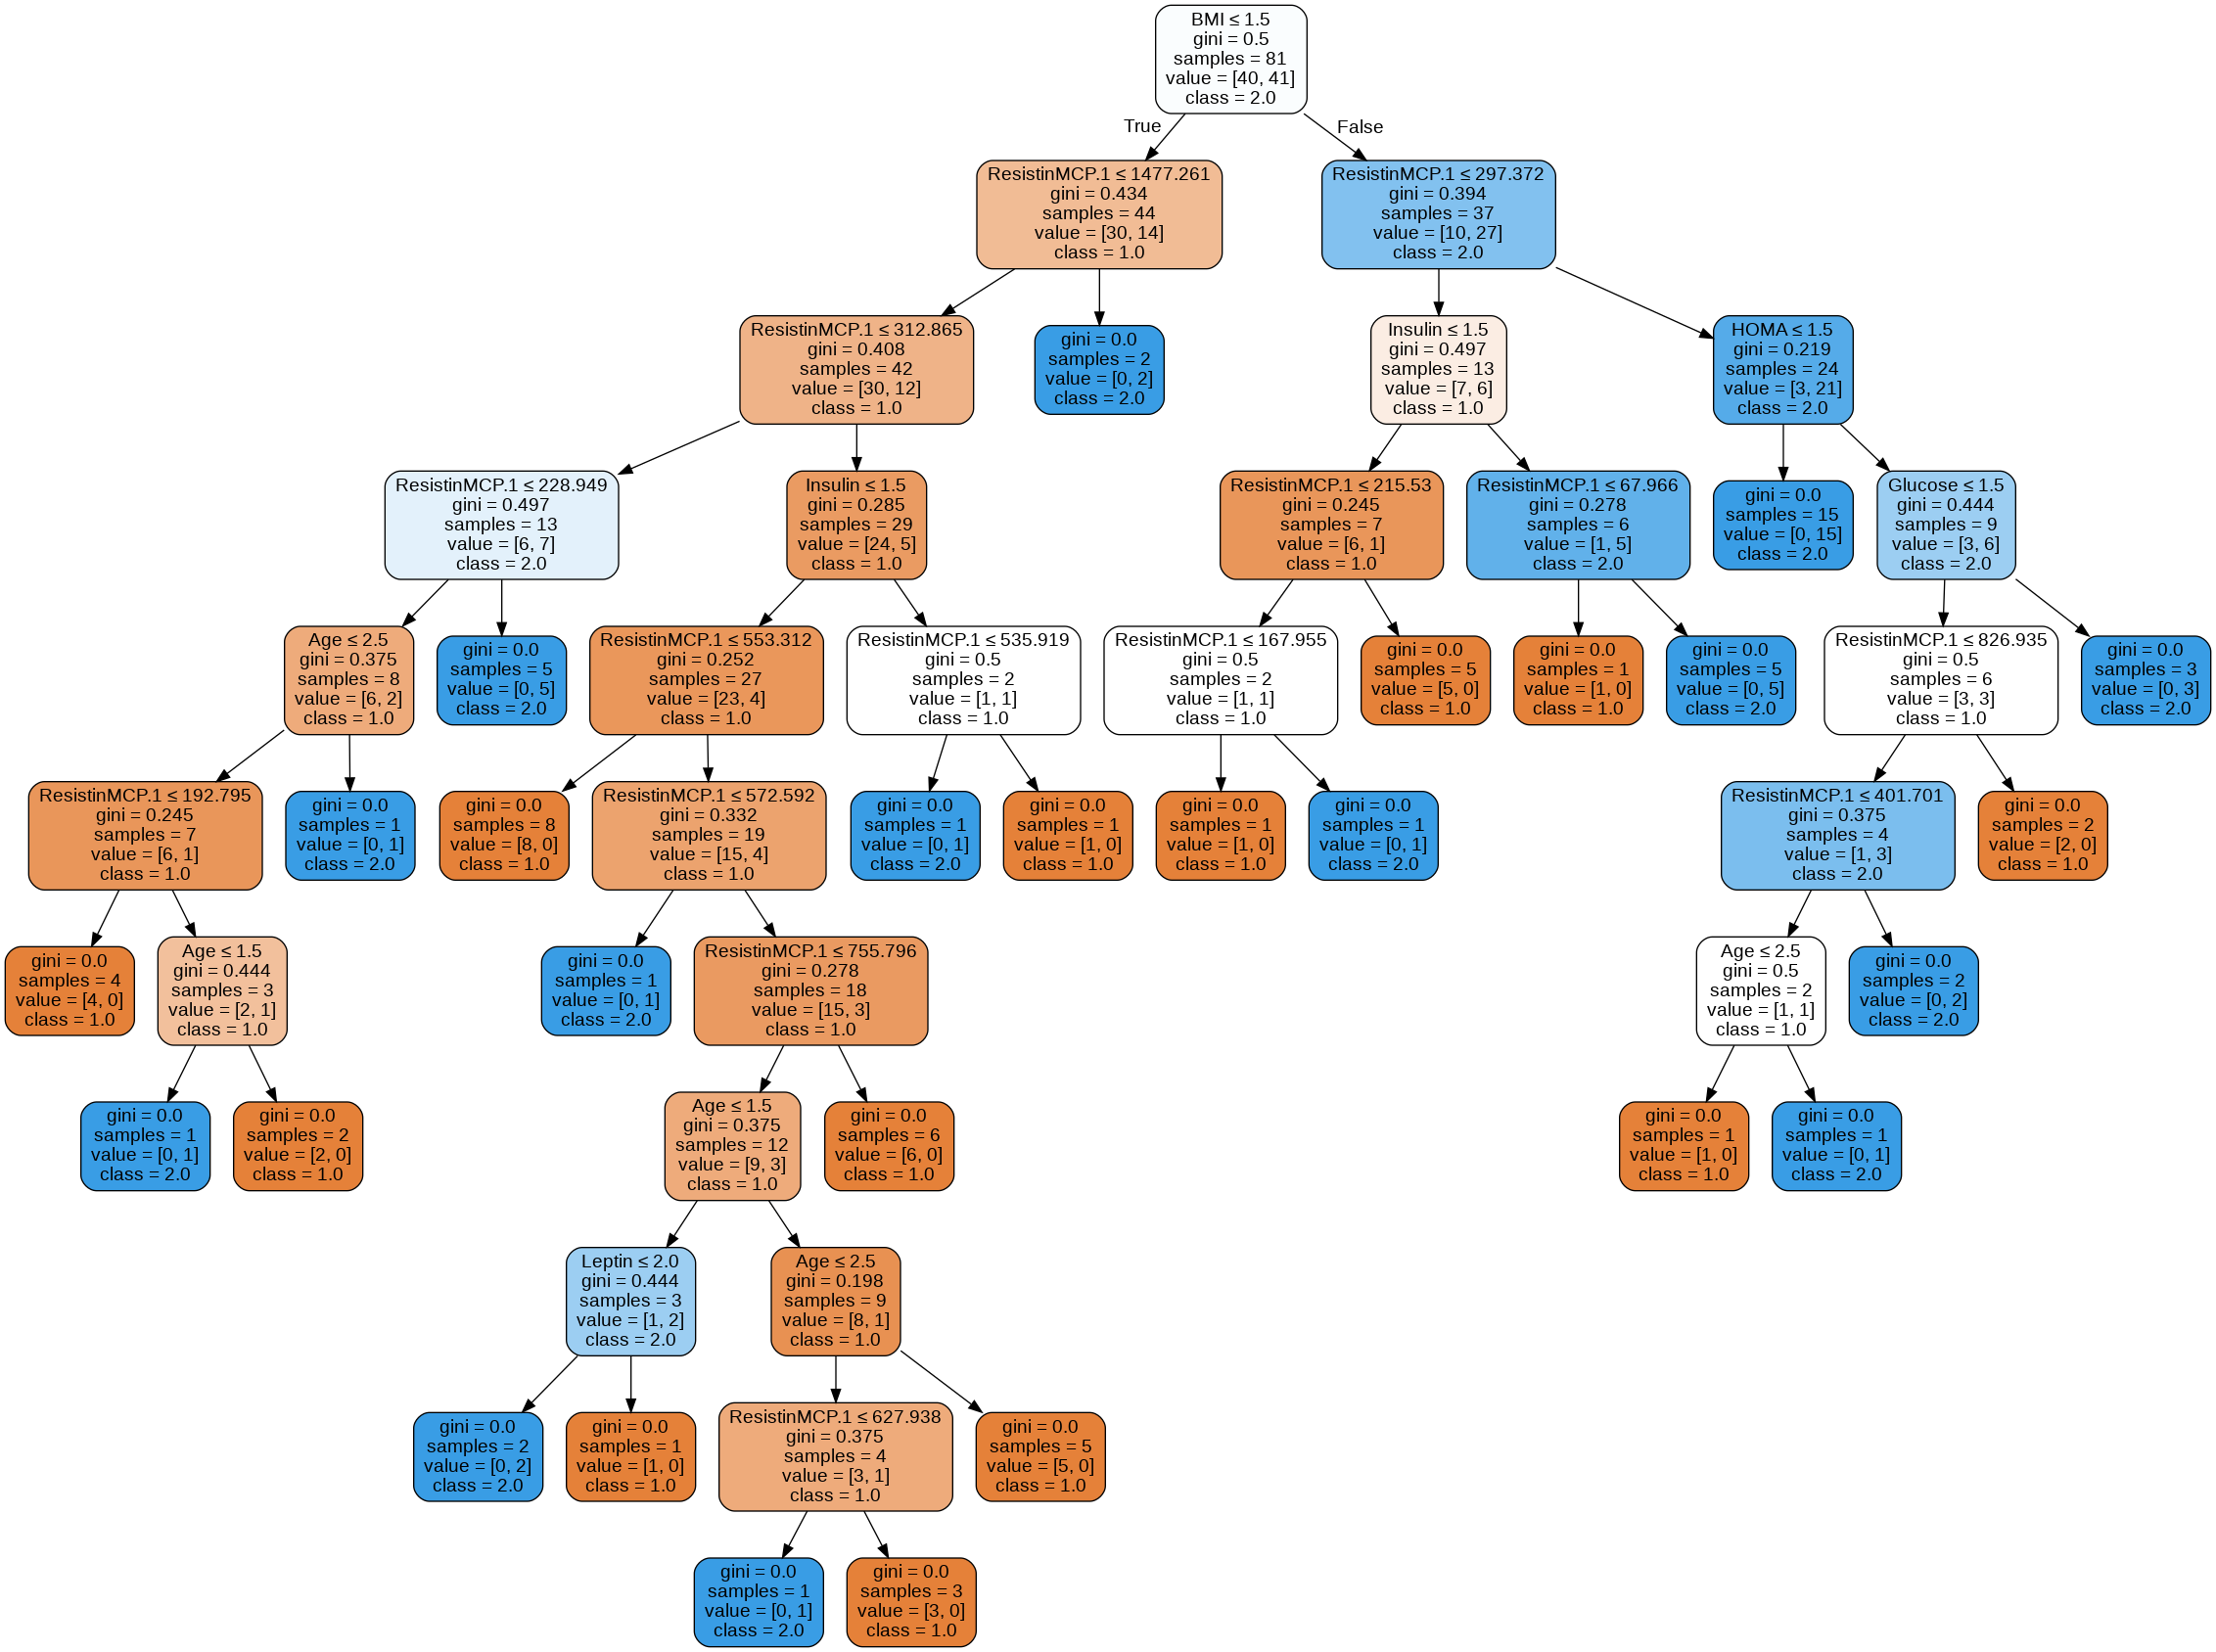

In [29]:
#split dataset in features and target variable
feature_cols = ['Age','BMI','Glucose','Insulin','HOMA','Leptin','Adiponectin','Resistin	MCP.1']

X = df[feature_cols] # Features
y = df.Classification # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#Print out the decision tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['1.0','2.0'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('BC.png')
Image(graph.create_png())

In [30]:
#Optimised Decision Tree

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['1.0','2.0'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('BC1.png')
Image(graph.create_png())

Accuracy: 0.6285714285714286


#SVM 

#Iris Dataset

In [31]:
col_names = ['SepalLength','SepalWidth', 'PetalLength', 'PetalWidth', 'Class']
df = pd.read_csv('iris-Updated.csv', header=None, names=col_names)
  																			
rows = len(df)
cols = len(df.columns)
print(rows)
print(cols)
df.head()

150
5


SepalLength  SepalWidth  PetalLength  PetalWidth        Class
0            1           3            1           1  Iris-setosa
1            1           1            1           1  Iris-setosa
2            1           2            1           1  Iris-setosa
3            1           2            1           1  Iris-setosa
4            1           3            1           1  Iris-setosa

In [32]:
#split dataset in features and target variable
feature_cols = ['SepalLength','SepalWidth', 'PetalLength', 'PetalWidth']


X = df[feature_cols] # Features
y = df.Class # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9555555555555556


#Wine Dataset

In [33]:
col_names = ['Alcohol','MalicAcid', 'Ash', 'AlcalinityOfAsh', 'Magnesium', 'TotalPhenols', 'Flavanoids', 'NonflavanoidPhenols', 'Proanthocyanins', 'ColorIntensity', 'Hue', 'OD280_OD315OfDilutedWines', 'Proline']
df = pd.read_csv('wine-Updated.csv', header=None, names=col_names)
  																			
rows = len(df)
cols = len(df.columns)
print(rows)
print(cols)
df.head()


178
13


Alcohol  MalicAcid  Ash  ...  Hue  OD280_OD315OfDilutedWines  Proline
3        2          2    1  ...    3                          4        1
3        2          2    1  ...    3                          4        1
3        3          2    2  ...    3                          4        1
3        2          2    1  ...    3                          4        1
3        3          2    2  ...    3                          2        1

[5 rows x 13 columns]

In [34]:
#split dataset in features and target variable
feature_cols = ['Alcohol','MalicAcid', 'Ash', 'AlcalinityOfAsh', 'Magnesium', 'TotalPhenols', 'Flavanoids', 'NonflavanoidPhenols', 'Proanthocyanins', 'ColorIntensity', 'Hue', 'OD280_OD315OfDilutedWines']


X = df[feature_cols] # Features
y = df.Proline # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9814814814814815


#Glass Dataset

In [35]:
col_names = ['IdNumber','RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
df = pd.read_csv('glass-Updated.csv', header=None, names=col_names)
  																			
rows = len(df)
cols = len(df.columns)
print(rows)
print(cols)
df.head()

214
10


IdNumber  RI  Na  Mg  Al  Si  K  Ca  Ba  Fe
1         3   1   2   1   2   1  3   1   1   1
1         2   1   2   1   2   2  2   1   1   1
1         1   1   2   2   2   2  2   1   1   1
1         2   1   2   1   2   2  2   1   1   1
1         2   1   2   1   2   2  2   1   1   1

In [36]:
#split dataset in features and target variable
feature_cols = ['IdNumber','RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba']


X = df[feature_cols] # Features
y = df.Fe # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7384615384615385


#Tic-tac-toe Dataset

In [37]:
col_names = ['top-left-square','top-middle-square', 'top-right-square', 'middle-left-square', 'middle-middle-square', 'middle-right-square', 'bottom-left-square', 'bottom-middle-square', 'bottom-right-square', 'Class']
df = pd.read_csv('tic-tac-toe-Updated.csv', header=None, names=col_names)
  																			
rows = len(df)
cols = len(df.columns)
print(rows)
print(cols)
df.head()

958
10


top-left-square  top-middle-square  ...  bottom-right-square     Class
0                2                  2  ...                    1  positive
1                2                  2  ...                    1  positive
2                2                  2  ...                    2  positive
3                2                  2  ...                    3  positive
4                2                  2  ...                    3  positive

[5 rows x 10 columns]

In [38]:
#split dataset in features and target variable
feature_cols = ['top-left-square','top-middle-square', 'top-right-square', 'middle-left-square', 'middle-middle-square', 'middle-right-square', 'bottom-left-square', 'bottom-middle-square', 'bottom-right-square']

X = df[feature_cols] # Features
y = df.Class # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6076388888888888


#Zoo Dataset

In [39]:
col_names = ['animal_name','hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize', 'Type']
df = pd.read_csv('zoo-Updated.csv', header=None, names=col_names)
  																			
rows = len(df)
cols = len(df.columns)
print(rows)
print(cols)
df.head()

101
18


animal_name  hair  feathers  eggs  milk  ...  legs  tail  domestic  catsize  Type
0           17     2         1     1     2  ...     6     1         1        2     1
1           56     2         1     1     2  ...     6     2         1        2     1
2           36     1         1     2     1  ...     3     2         1        1     4
3           85     2         1     1     2  ...     6     1         1        2     1
4           41     2         1     1     2  ...     6     2         1        2     1

[5 rows x 18 columns]

In [40]:
#split dataset in features and target variable
feature_cols = ['animal_name','hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize']

X = df[feature_cols] # Features
y = df.Type # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.967741935483871


#tae

In [41]:
col_names = ['TA_native_English_speaker','Course_instructor','Course','Summer_or_regular_semester', 'Class_size','Class']
df = pd.read_csv('tae-Updated.csv', header=None, names=col_names)
																				
rows = len(df)
cols = len(df.columns)
print(rows)
print(cols)
df.head()

151
6


TA_native_English_speaker  Course_instructor  ...  Class_size  Class
0                          1                 10  ...           1      3
1                          2                 14  ...           1      3
2                          1                 10  ...           3      3
3                          1                  4  ...           2      3
4                          2                  5  ...           3      3

[5 rows x 6 columns]

In [42]:
#split dataset in features and target variable
feature_cols = ['TA_native_English_speaker','Course_instructor','Course','Summer_or_regular_semester', 'Class_size']


X = df[feature_cols] # Features
y = df.Class # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.43478260869565216


#Breast-Cancer

In [43]:
col_names = ['Age','BMI','Glucose','Insulin','HOMA','Leptin','Adiponectin','Resistin	MCP.1','Classification']
df = pd.read_csv('BreastCancerCoimbraDataSet-Updated.csv', header=None, names=col_names)
																				
rows = len(df)
cols = len(df.columns)
print(rows)
print(cols)
df.head()

116
9


Age  BMI  Glucose  ...  Adiponectin  Resistin\tMCP.1  Classification
2    1    1        1  ...            1          417.114             1.0
2    1    1        1  ...            1          468.786             1.0
2    1    1        1  ...            1          554.697             1.0
2    1    1        1  ...            1          928.220             1.0
2    1    1        1  ...            1          773.920             1.0

[5 rows x 9 columns]

In [44]:
#split dataset in features and target variable
feature_cols = ['Age','BMI','Glucose','Insulin','HOMA','Leptin','Adiponectin','Resistin	MCP.1']

X = df[feature_cols] # Features
y = df.Classification # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6857142857142857
